# Mean-Field Optimal Execution - DGM report

> Tip: The notebook assumes `mf_optimal_execution` package is installed (editable mode is fine):  
> `pip install -e ..` and restart the kernel.

In [1]:
from pathlib import Path

import torch
import numpy as np
import matplotlib.pyplot as plt

from mf_optimal_execution.models import PriceImpactModel
from mf_optimal_execution.solutions import OptimalExecutionSolutionPDE_MFG
from mf_optimal_execution.networks import DGMModel
from mf_optimal_execution.utils import setup_plt
from mf_optimal_execution.config import Config

In [2]:
CHECKPOINTS_PATH = Path("../checkpoints")

checkpoint_path = None
if checkpoint_path is None:
    candidates = sorted((p for p in CHECKPOINTS_PATH.glob("dgm_mfg_*.pt")), key=lambda p: p.stat().st_mtime, reverse=True)
    checkpoint_path = candidates[0]

print(f"Will load: '{checkpoint_path.name}'")

Will load: 'dgm_mfg_1760150097.pt'


## Load checkpoint

In [3]:
setup_plt()

ckpt = torch.load(checkpoint_path)

cfg = Config(**ckpt["config"])


dyn = PriceImpactModel(cfg.sigma, cfg.gamma, cfg.ca, cfg.cx, cfg.cg)
sol = OptimalExecutionSolutionPDE_MFG(dyn, cfg)

# Recreate and load model
model = DGMModel(dyn, cfg.maturity, cfg.x0_mean, cfg.x0_std)
model.load_state_dict(ckpt["model"], strict=True)
model.eval()

# Training curve
losses = ckpt.get("losses", None)

## Plot results

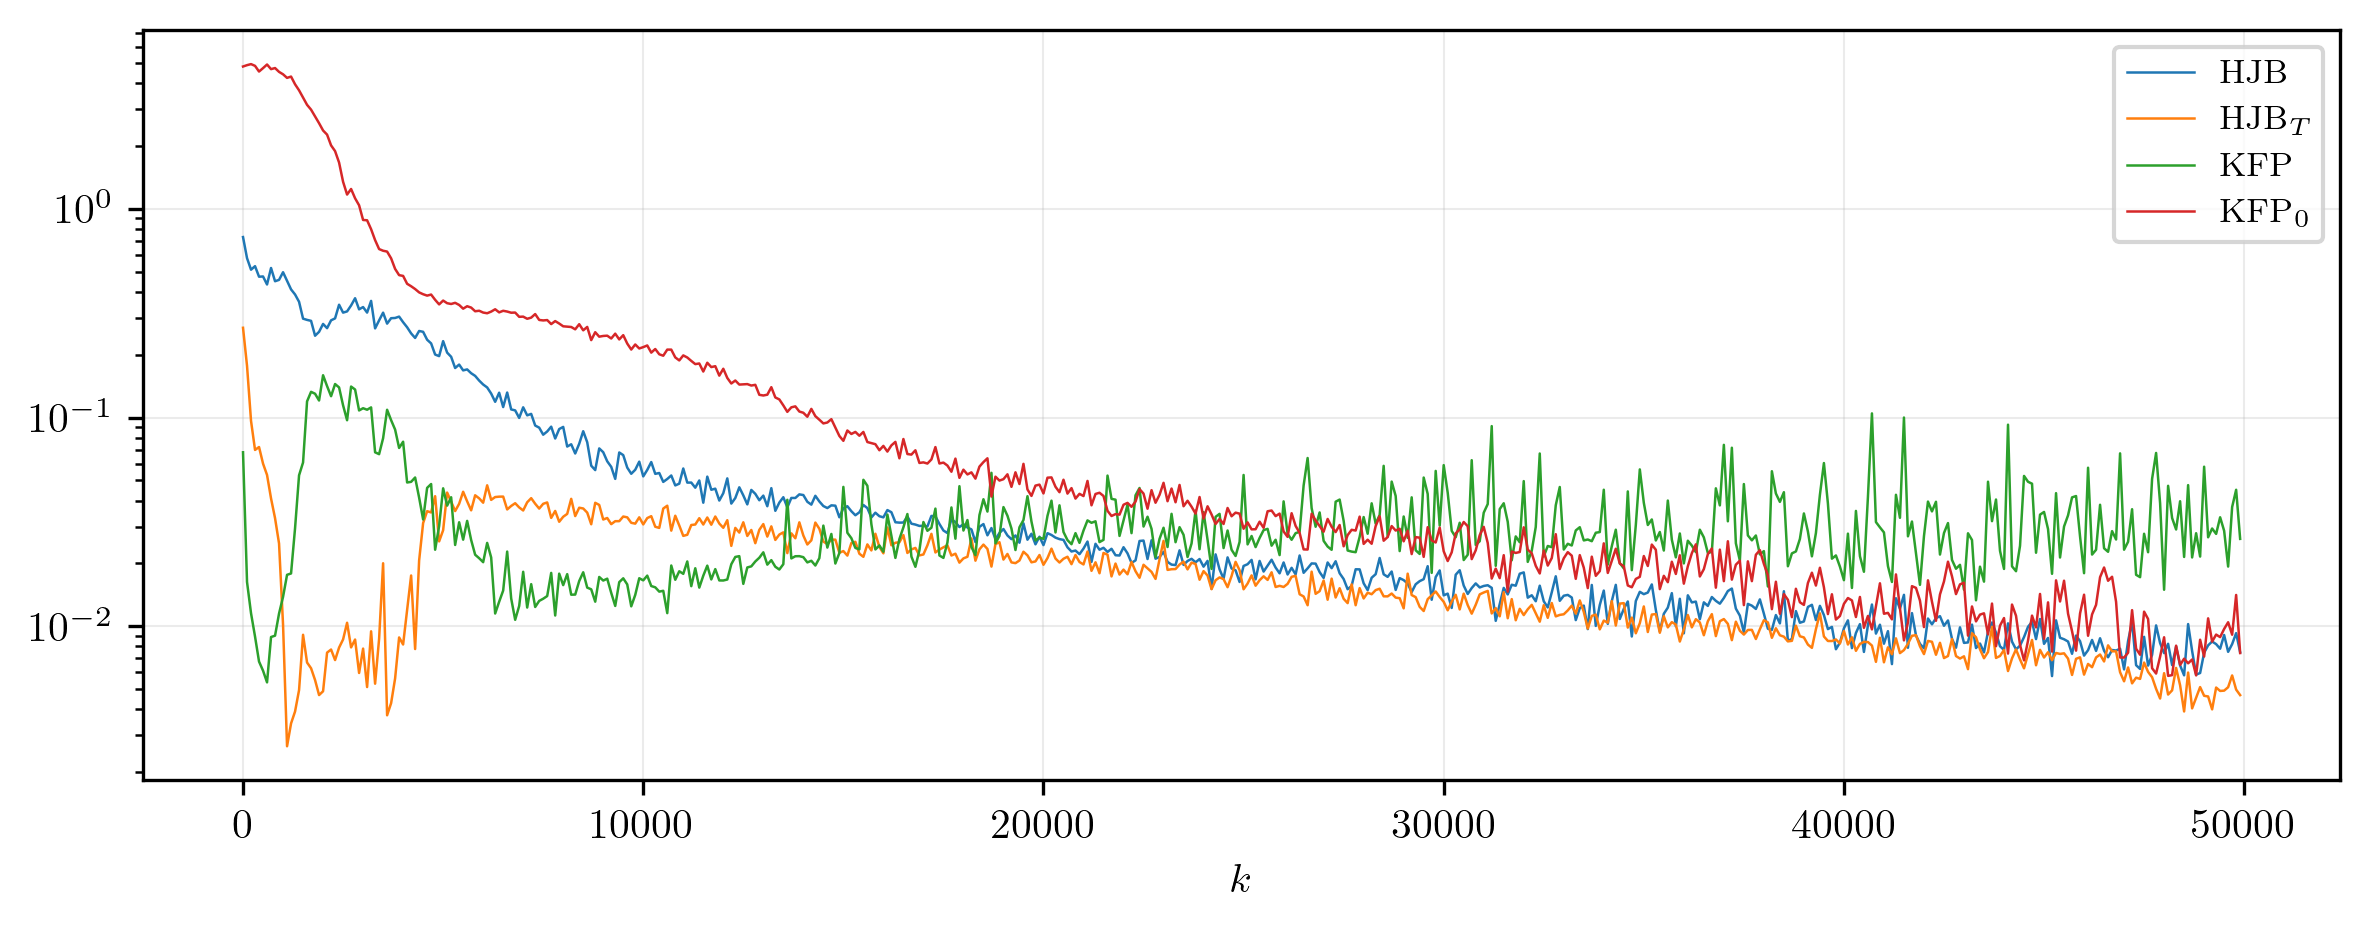

In [4]:
x_epoch = np.arange(losses.size(0)) * 100

labels = [r"$\mathrm{HJB}$", r"$\mathrm{HJB}_T$", r"$\mathrm{KFP}$", r"$\mathrm{KFP}_0$"]

fig, ax = plt.subplots(1, 1, figsize=(8, 3.2), dpi=300)

for i in range(losses.size(1)):
    ax.plot(x_epoch, losses[:, i], lw=0.6, label=labels[i])
ax.set_xlabel("$k$")
ax.set_yscale("log")
ax.grid(lw=0.5, alpha=0.25)
ax.legend(fontsize=8)

fig.tight_layout()
plt.show()

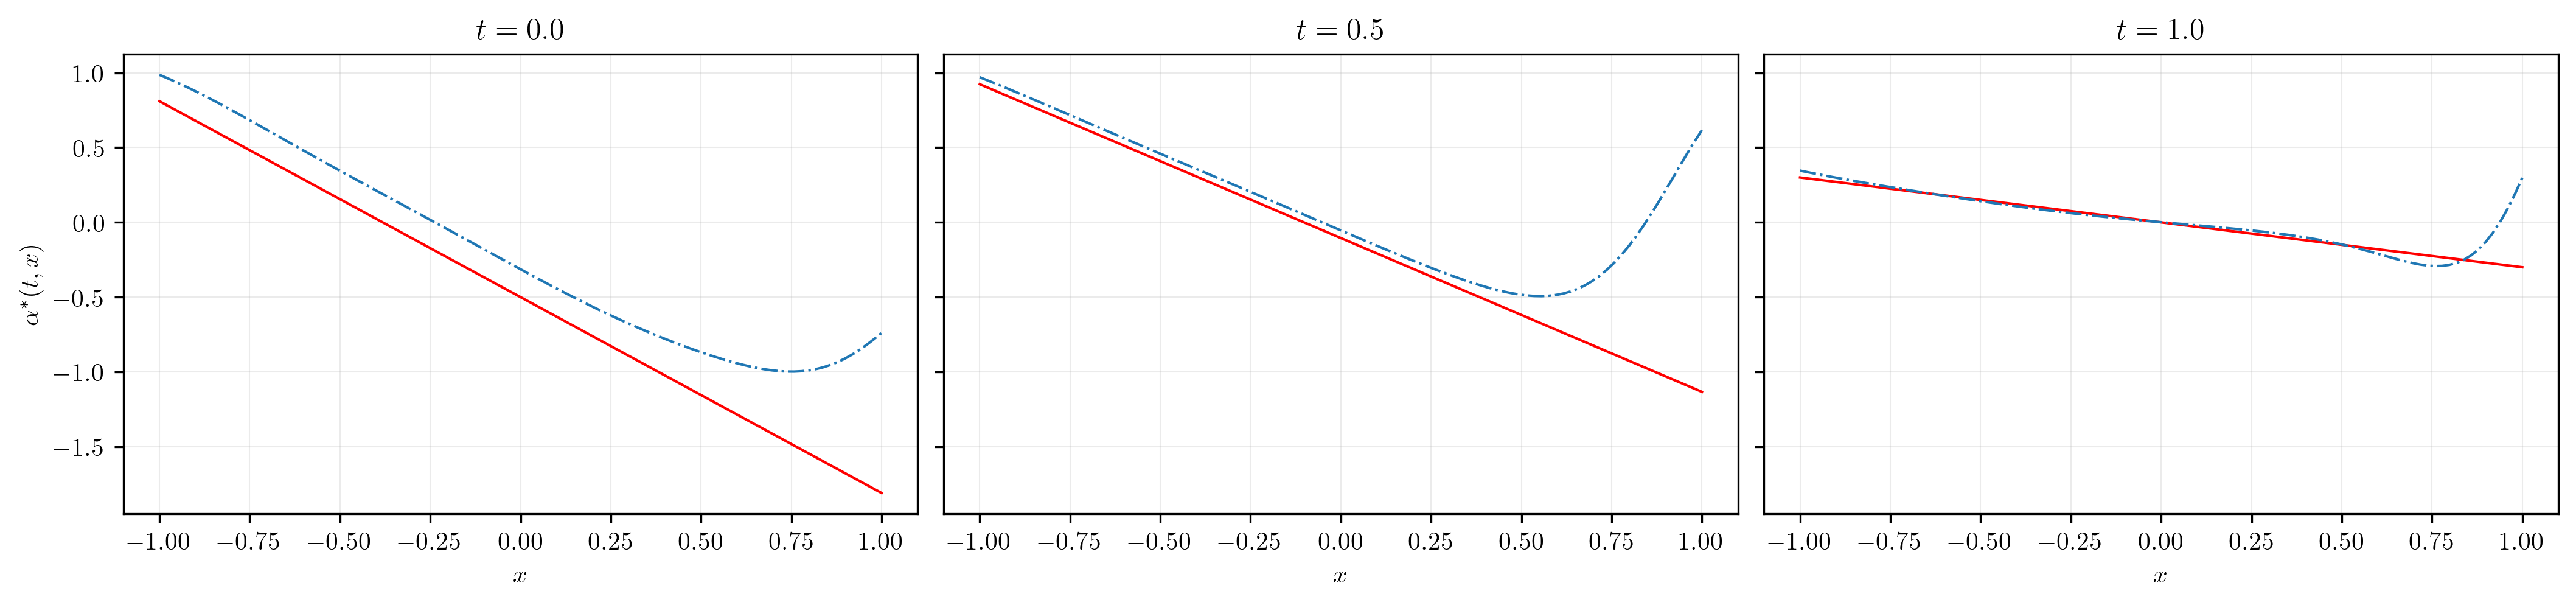

In [5]:
x_min, x_max = -1.0, 1.0

xx = torch.linspace(x_min, x_max, 100, requires_grad=True).unsqueeze(1)

fig, axs = plt.subplots(1, 3, figsize=(14, 3.2), dpi=300, sharey=True, constrained_layout=True)

for t, ax in zip([0.0, 0.5, 1.0], axs):
    tt = torch.full_like(xx, fill_value=t, requires_grad=True)
    aa = -torch.autograd.grad(model.v_net(tt, xx), xx, grad_outputs=torch.ones_like(xx))[0] / cfg.ca
    ax.plot(xx.detach(), sol.alpha(t, xx.detach()), lw=1, c="red")
    ax.plot(xx.detach(), aa.detach(), lw=1, ls="-.")
    ax.grid(lw=0.5, alpha=0.25)
    ax.set_title(rf"$t={t}$")
    ax.set_xlabel(r"$x$")
    if t == 0.0:
        ax.set_ylabel(r"$\alpha^*(t,x)$")

plt.show()

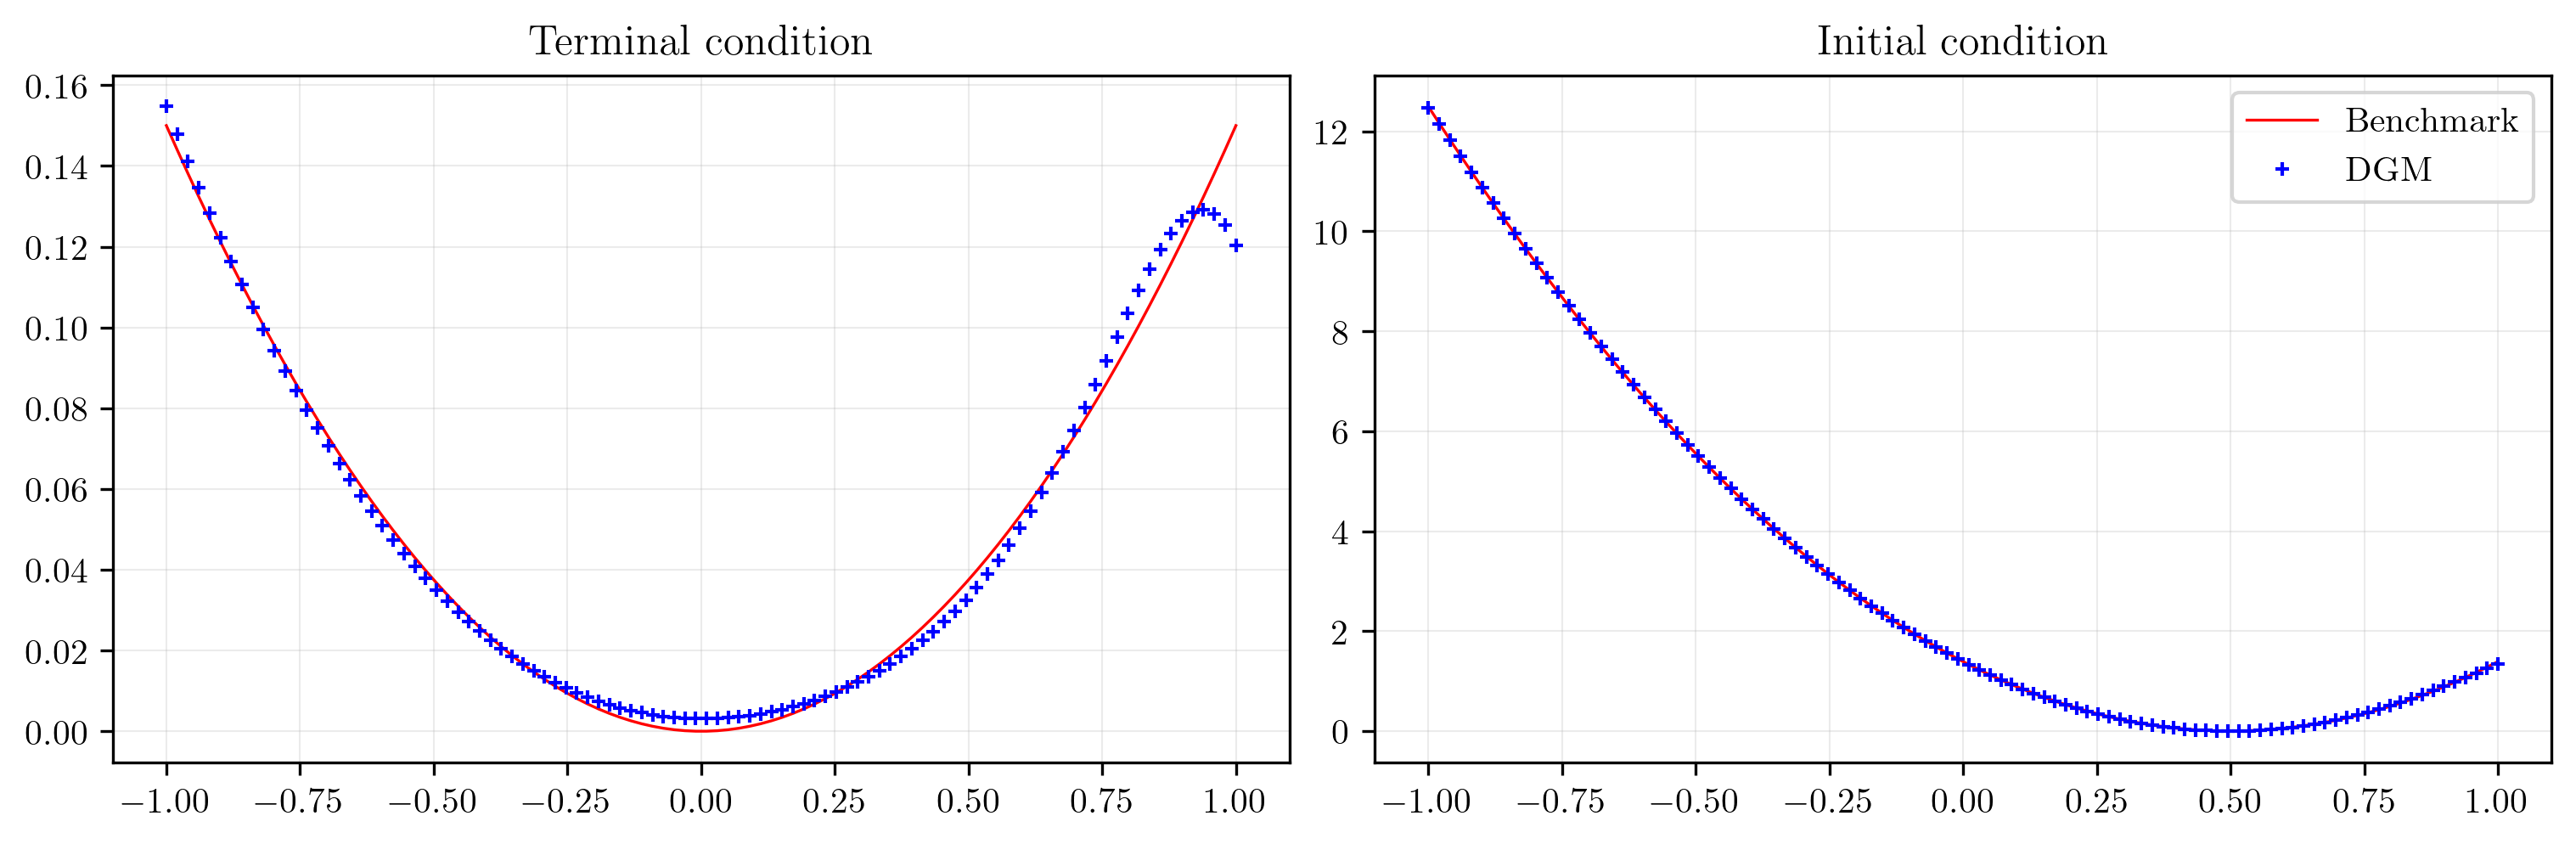

In [6]:
xx = torch.linspace(x_min, x_max, 100).unsqueeze(1)
tt = torch.full_like(xx, fill_value=1)

fig, axs = plt.subplots(1, 2, figsize=(10, 3.2), dpi=300, sharex=True, constrained_layout=True)

with torch.no_grad():
    v_true = model.v_net.terminal_value(xx)
    v_pred = model.v_net(torch.ones_like(xx) * cfg.maturity, xx)
    u_true = model.u_net.initial_value(xx)
    u_pred = model.u_net(torch.zeros_like(xx), xx)

axs[0].plot(xx, v_true, lw=0.8, c="red", label="Benchmark")
axs[0].plot(xx, v_pred, "+", c="blue", label="DGM", ms=4)
axs[0].set_title("Terminal condition")
axs[0].grid(lw=0.5, alpha=0.25)

axs[1].plot(xx, u_true, lw=0.8, c="red", label="Benchmark")
axs[1].plot(xx, u_pred, "+", c="blue", label="DGM", ms=4)
axs[1].set_title("Initial condition")
axs[1].grid(lw=0.5, alpha=0.25)
axs[1].legend(loc="upper right")

plt.show()